In [1]:
# --- Paths (edit as needed) ---
MODEL_CKPT   = "./checkpoints/ckpt_last.pt"
TEST_H5      = "./DATA/test.h5"
CATALOG_CSV  = "./DATA/test.csv"
SAVE_CSV     = "./DATA/test_with_nn_flags_twostage.csv"

# --- Eval parameters ---
THRESHOLD    = 0.50     # pixelwise threshold (unchanged from your old workflow)
RADIUS_PX    = 3        # acceptance disk radius around (x,y)
TILE         = 128      # tile size for inference
BASE_THR     = 0.05     # seed threshold for FDS components
PIXEL_GAP    = RADIUS_PX
LINE_WIDTH   = 1
LINE_LEN     = 25
CLF_THR      = 0.50     # classifier probability threshold for accepting components

SEED         = 42
DEVICE       = "cuda"


In [2]:
import os, math, numpy as np, pandas as pd, torch, h5py
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import warnings, random
warnings.filterwarnings("ignore")

# your project modules
from ADCNN.models.unet_res_se import UNetResSEASPP
from ADCNN.data.h5tiles import H5TiledDataset

# tiny deps (try to import, install if missing)
try:
    import lightgbm  # noqa: F401
except Exception:
    try:
        import sys
        !{sys.executable} -m pip -q install lightgbm
    except Exception:
        pass

try:
    import sklearn  # noqa: F401
except Exception:
    import sys
    !{sys.executable} -m pip -q install scikit-learn

# seeds
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
torch.backends.cudnn.benchmark = True

print("Device:", torch.device(DEVICE if torch.cuda.is_available() else "cpu"))


Device: cuda


In [3]:
def pixelwise_confusion(p_full, gt_full, thr):
    gt = (gt_full > 0).astype(np.uint8); pred = (p_full >= thr).astype(np.uint8)
    tp = int(((pred==1)&(gt==1)).sum()); fp = int(((pred==1)&(gt==0)).sum())
    fn = int(((pred==0)&(gt==1)).sum()); tn = int(((pred==0)&(gt==0)).sum())
    prec = tp / max(tp+fp, 1); rec = tp / max(tp+fn, 1)
    f1 = 2*prec*rec / max(prec+rec, 1e-12)
    beta2 = 2.0; f2 = (1+beta2**2)*prec*rec / max(beta2**2*prec + rec, 1e-12)
    return (tp,fp,fn,tn), (prec,rec,f1,f2)

def print_confusion_matrix(cm, title="Confusion Matrix"):
    tp,fp,fn,tn = cm
    df = pd.DataFrame([[tp, fp],
                       [fn, tn]],
                      index=["Actual +", "Actual -"],
                      columns=["Pred +", "Pred -"])
    print(title)
    display(df.style.format(na_rep="-").set_properties(**{"text-align":"center"}))

def rough_auc_from_scores(scores, labels):
    s = scores.astype(np.float32); y = labels.astype(bool)
    order = np.argsort(-s); y2 = y[order]
    tpr = np.cumsum(y2) / max(y2.sum(), 1)
    fpr = np.cumsum(~y2) / max((~y2).sum(), 1)
    auc = np.trapz(tpr, fpr)
    return fpr, tpr, auc


In [4]:
@torch.no_grad()
def load_model(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    model = UNetResSEASPP(in_ch=1, out_ch=1)
    model.load_state_dict(ckpt["state"])
    model.eval()
    return model

@torch.no_grad()
def predict_tiles_to_full(h5_path, loader, model, tile=TILE, device="cuda"):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model.eval().to(device)
    with h5py.File(h5_path, "r") as f:
        N, H, W = f["images"].shape
    xb0, _ = next(iter(loader))
    oh, ow = model(xb0[:1].to(device))[:,0].shape[-2:]
    full = np.zeros((N, H, W), np.float32)
    buf = []; ptr = 0
    Hb, Wb = (int(np.ceil(H/tile)), int(np.ceil(W/tile)))
    tpp = Hb * Wb
    for xb, _ in loader:
        pr = model(xb.to(device))[:,0]
        if (oh,ow) != (tile,tile):
            pr = F.interpolate(pr.unsqueeze(1), (tile,tile), mode="bilinear", align_corners=False).squeeze(1)
        pr = torch.sigmoid(pr).cpu().numpy()
        buf.extend(list(pr))
        while len(buf) >= tpp:
            p = ptr // tpp
            if p >= N: break
            panel = np.zeros((Hb*tile, Wb*tile), np.float32)
            for r in range(Hb):
                for c in range(Wb):
                    t_idx = r*Wb + c
                    panel[r*tile:(r+1)*tile, c*tile:(c+1)*tile] = buf[t_idx]
            full[p] = panel[:H,:W]
            buf = buf[tpp:]; ptr += tpp
    return full

# data & predict
test_ds = H5TiledDataset(TEST_H5, tile=TILE, k_sigma=5.0)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)
print("Tiles:", len(test_ds), "| images:", test_ds.N, f"| panel size: {test_ds.H}x{test_ds.W}")

model = load_model(MODEL_CKPT)
p_full = predict_tiles_to_full(TEST_H5, test_loader, model, tile=TILE, device=DEVICE)
with h5py.File(TEST_H5, "r") as f:
    gt_full = f["masks"][:].astype(np.uint8)

print("Predictions:", p_full.shape)


Tiles: 51200 | images: 50 | panel size: 4000x4072
Predictions: (50, 4000, 4072)


In [5]:
# === Memory-safe label orientation from raw moments (no H×W×labels arrays) ===
def _label_orientations_raw_moments(labels: np.ndarray, ids: np.ndarray):
    """
    Compute component orientations using raw moments:
      m00 = Σ 1
      m10 = Σ x,  m01 = Σ y
      m20 = Σ x^2, m02 = Σ y^2, m11 = Σ x y
    Then central moments:
      mu20 = m20 - 2*xc*m10 + m00*xc^2
      mu02 = m02 - 2*yc*m01 + m00*yc^2
      mu11 = m11 - xc*m01 - yc*m10 + m00*xc*yc
    Major-axis angle: 0.5 * atan2(2*mu11, mu20 - mu02) in degrees ∈ [0, 180)
    Returns:
      angles_deg [n_labels], areas [n_labels]
    """
    H, W = labels.shape
    yy = np.arange(H, dtype=np.float32)[:, None]
    xx = np.arange(W, dtype=np.float32)[None, :]

    ones = np.ones_like(labels, dtype=np.float32)
    m00 = ndi.sum(ones, labels=labels, index=ids)                 # area
    m10 = ndi.sum(xx,   labels=labels, index=ids)                 # sum x
    m01 = ndi.sum(yy,   labels=labels, index=ids)                 # sum y
    m20 = ndi.sum(xx*xx,labels=labels, index=ids)                 # sum x^2
    m02 = ndi.sum(yy*yy,labels=labels, index=ids)                 # sum y^2
    m11 = ndi.sum(xx*yy,labels=labels, index=ids)                 # sum x*y

    # centroids
    xc = m10 / np.maximum(m00, 1e-6)
    yc = m01 / np.maximum(m00, 1e-6)

    # central moments
    mu20 = m20 - 2*xc*m10 + m00*(xc**2)
    mu02 = m02 - 2*yc*m01 + m00*(yc**2)
    mu11 = m11 - xc*m01 - yc*m10 + m00*(xc*yc)

    angles = 0.5*np.degrees(np.arctan2(2*mu11, (mu20 - mu02))).astype(np.float32)
    angles[angles < 0] += 180.0
    return angles, m00


In [8]:
# FAST component builder: precompute orientation response bank per panel
from dataclasses import dataclass

K_ORIENT = 16            # number of angles in the bank (8–24 is fine)
ANGLES = np.linspace(0, 180, K_ORIENT, endpoint=False).astype(np.float32)
MIN_AREA = 4             # skip tiny blobs to reduce label count

# --- small helpers reused ---
def _label_components_fds(mask_bool, pixel_gap=PIXEL_GAP):
    if pixel_gap > 1:
        grown = ndi.binary_dilation(mask_bool, structure=np.ones((2*pixel_gap+1,2*pixel_gap+1), bool))
    else:
        grown = mask_bool
    labels, n = ndi.label(grown, structure=np.ones((3,3), bool))
    return labels, int(n)

def _oriented_kernel(angle_deg: float, length: int=LINE_LEN, width: int=LINE_WIDTH):
    L = int(length); th = np.deg2rad(angle_deg)
    dy, dx = np.sin(th), np.cos(th)
    H = W = 2*L + 1
    ker = np.zeros((H,W), np.float32)
    ys = np.linspace(-L, L, 2*L+1)
    y = (H//2) + ys*dy
    x = (W//2) + ys*dx
    y = np.clip(np.rint(y).astype(int), 0, H-1)
    x = np.clip(np.rint(x).astype(int), 0, W-1)
    ker[y, x] = 1.0
    if width > 1:
        ker = ndi.binary_dilation(ker, structure=np.ones((width, width))).astype(np.float32)
    s = ker.sum()
    if s > 0: ker /= s
    return ker

# --- moment-based orientation per label (vectorized; no Python loops over pixels) ---
def _label_moments_angles(labels: np.ndarray, ids: np.ndarray) -> np.ndarray:
    # build coordinate grids once
    H, W = labels.shape
    yy = np.arange(H, dtype=np.float32)[:, None]
    xx = np.arange(W, dtype=np.float32)[None, :]

    # sums over each label id
    area   = ndi.sum(np.ones_like(labels, np.float32), labels=labels, index=ids)
    y_sum  = ndi.sum(yy, labels=labels, index=ids)
    x_sum  = ndi.sum(xx, labels=labels, index=ids)

    # centers
    yc = y_sum / np.maximum(area, 1e-6)
    xc = x_sum / np.maximum(area, 1e-6)

    # central moments
    y2 = ndi.sum((yy - yc[:, None, None])**2, labels=labels, index=ids)
    x2 = ndi.sum((xx - xc[:, None, None])**2, labels=labels, index=ids)
    xy = ndi.sum((yy - yc[:, None, None])*(xx - xc[:, None, None]), labels=labels, index=ids)

    # covariance elements (unnormalized by area; ok for angle)
    # angle of major axis = 0.5*atan2(2*mu11, mu20 - mu02)
    angles = 0.5*np.degrees(np.arctan2(2*xy, y2 - x2)).astype(np.float32)
    angles[angles < 0] += 180.0
    # elongation proxy if needed: sqrt(mu_major / mu_minor)
    return angles, area

# --- main fast builder over all panels ---
# === Memory-safe fast builder: no [K,H,W] stack; reduce to [K, n_labels] ===
K_ORIENT = 16
ANGLES   = np.linspace(0, 180, K_ORIENT, endpoint=False).astype(np.float32)
MIN_AREA = 4

import time, sys

def panels_to_component_df_fast_memsafe(
        p_full: np.ndarray,
        gt_full: np.ndarray,
        base_thr: float = BASE_THR,
        pixel_gap: int = PIXEL_GAP,
        verbose: bool = True,
    ) -> pd.DataFrame:
    """
    Memory-safe builder with per-panel progress feedback.
    Prints every few panels with speed and ETA.
    """
    rows = []
    n_panels = p_full.shape[0]
    t0 = time.time()

    for pid in range(n_panels):
        t_start = time.time()
        prob = p_full[pid]
        gt   = (gt_full[pid] > 0)

        # seed & labels
        mask = prob >= base_thr
        labels, n = _label_components_fds(mask, pixel_gap=pixel_gap)
        if n == 0:
            if verbose:
                print(f"[{pid+1:3d}/{n_panels}] no components (skip)")
            continue

        ids = np.arange(1, n+1, dtype=np.int32)

        # filter small
        areas = ndi.sum(np.ones_like(labels, np.float32), labels=labels, index=ids).astype(np.int32)
        keep = areas >= MIN_AREA
        if not np.any(keep):
            if verbose:
                print(f"[{pid+1:3d}/{n_panels}] all below MIN_AREA")
            continue
        ids   = ids[keep]
        areas = areas[keep]

        mean_p = ndi.sum(prob, labels=labels, index=ids) / np.maximum(areas, 1)
        max_p  = ndi.maximum(prob, labels=labels, index=ids)
        overlap = (ndi.sum(gt.astype(np.uint8), labels=labels, index=ids) > 0)

        # bboxes
        slices = ndi.find_objects(labels)
        bbox_h = np.empty_like(areas)
        bbox_w = np.empty_like(areas)
        for j, cid in enumerate(ids):
            sl = slices[cid-1]
            bbox_h[j] = sl[0].stop - sl[0].start
            bbox_w[j] = sl[1].stop - sl[1].start

        # orientations (lightweight)
        angles, _ = _label_orientations_raw_moments(labels, ids)

        # K convolutions reduced to [K,n_labels]
        sums_KL = np.empty((len(ANGLES), len(ids)), dtype=np.float32)
        for k, a in enumerate(ANGLES):
            ker = _oriented_kernel(float(a), length=LINE_LEN, width=LINE_WIDTH)
            rmap = ndi.convolve(prob, ker, mode="nearest")
            sums_KL[k, :] = ndi.sum(rmap, labels=labels, index=ids)

        idx = np.argmin(np.abs(angles[:, None] - ANGLES[None, :]), axis=1)
        line_sum = sums_KL[idx, np.arange(len(ids))]
        line_mean = line_sum / np.maximum(areas, 1)

        # collect rows
        for j, cid in enumerate(ids):
            rows.append(dict(
                image_id=int(pid), comp_id=int(cid),
                area=int(areas[j]),
                bbox_h=int(bbox_h[j]), bbox_w=int(bbox_w[j]),
                mean_p=float(mean_p[j]),
                med_p=0.0,  # skipped median
                max_p=float(max_p[j]),
                line_mean=float(line_mean[j]),
                angle_deg=float(angles[j]),
                major_std=np.nan, minor_std=np.nan, elong=np.nan,
                y_mean=np.nan, x_mean=np.nan,
                overlap_gt=bool(overlap[j]),
            ))

        # progress info
        if verbose:
            elapsed = time.time() - t_start
            done = pid + 1
            total_t = time.time() - t0
            avg_t = total_t / done
            eta = avg_t * (n_panels - done)
            sys.stdout.write(f"\r[{done:3d}/{n_panels}] comps={len(ids):5d} "
                             f"time={elapsed:5.1f}s | avg={avg_t:4.1f}s | ETA≈{eta/60:5.1f} min   ")
            sys.stdout.flush()

        del labels  # free memory

    if verbose:
        sys.stdout.write("\n")
        print(f"Finished all {n_panels} panels in {(time.time()-t0)/60:.2f} min, "
              f"{len(rows)} components total.")
    return pd.DataFrame(rows)

[ 50/50] comps= 1156 time=  8.2s | avg= 8.3s | ETA≈  0.0 min   
Finished all 50 panels in 6.88 min, 40587 components total.
components: 40587 | positives: 796


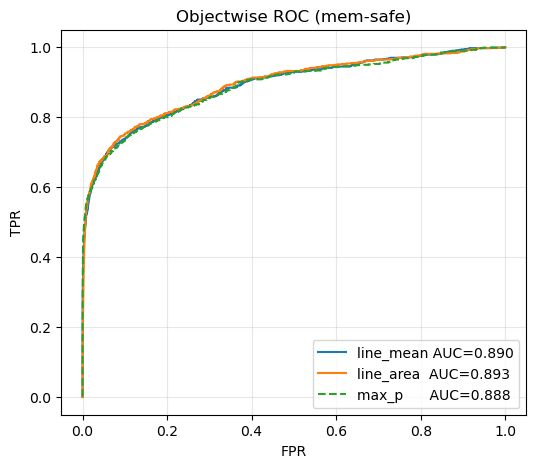

In [9]:
# --- run the memory-safe builder ---
comp_df = panels_to_component_df_fast_memsafe(p_full, gt_full, base_thr=BASE_THR, pixel_gap=PIXEL_GAP)
print("components:", len(comp_df), "| positives:", int(comp_df["overlap_gt"].sum()))

# Scores for ROC (vector ops on 1D arrays)
s_lineA = (comp_df["line_mean"].to_numpy(np.float32) * np.sqrt(comp_df["area"].to_numpy(np.float32)))
s_line  = comp_df["line_mean"].to_numpy(np.float32)
s_max   = comp_df["max_p"].to_numpy(np.float32)
y       = comp_df["overlap_gt"].to_numpy(np.bool_)

fpr_l,  tpr_l,  auc_l  = rough_auc_from_scores(s_line,  y)
fpr_la, tpr_la, auc_la = rough_auc_from_scores(s_lineA, y)
fpr_mx, tpr_mx, auc_mx = rough_auc_from_scores(s_max,   y)

plt.figure(figsize=(6,5))
plt.plot(fpr_l,  tpr_l,  label=f"line_mean AUC={auc_l:.3f}")
plt.plot(fpr_la, tpr_la, label=f"line_area  AUC={auc_la:.3f}")
plt.plot(fpr_mx, tpr_mx, label=f"max_p      AUC={auc_mx:.3f}", ls="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Objectwise ROC (mem-safe)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

In [10]:
FEATURES = ["area","bbox_h","bbox_w","mean_p","med_p","max_p","line_mean",
            "major_std","minor_std","elong"]

X = comp_df[FEATURES].to_numpy(np.float32)
Y = comp_df["overlap_gt"].astype(np.uint8).to_numpy()

# Prefer LightGBM; fallback sklearn GBM
backend = "lightgbm"
model = None
try:
    import lightgbm as lgb
    w_pos = float((len(Y) - Y.sum()) / max(Y.sum(), 1))
    ds = lgb.Dataset(X, label=Y)
    params = dict(objective="binary", metric="auc",
                  learning_rate=0.05, num_leaves=31, max_depth=-1,
                  min_data_in_leaf=50, bagging_fraction=0.8, feature_fraction=0.9,
                  scale_pos_weight=max(1.0, w_pos), verbose=-1)
    model = lgb.train(params, ds, num_boost_round=600)
except Exception:
    backend = "sklearn"
    from sklearn.ensemble import GradientBoostingClassifier
    model = GradientBoostingClassifier(loss="log_loss", learning_rate=0.05,
                                       n_estimators=600, max_depth=3)
    model.fit(X, Y)

print("two-stage classifier backend:", backend)


two-stage classifier backend: lightgbm


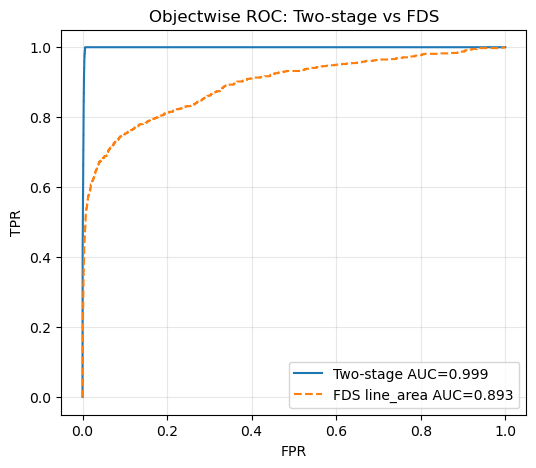

In [11]:
if hasattr(model, "predict_proba"):
    s_clf = model.predict_proba(X)[:,1]
elif hasattr(model, "decision_function"):
    import scipy.special as sp
    s_clf = sp.expit(model.decision_function(X))
else:
    s_clf = model.predict(X).astype(np.float32)

fpr_clf, tpr_clf, auc_clf = rough_auc_from_scores(s_clf, Y)

plt.figure(figsize=(6,5))
plt.plot(fpr_clf, tpr_clf, label=f"Two-stage AUC={auc_clf:.3f}")
plt.plot(fpr_la,  tpr_la,  label=f"FDS line_area AUC={auc_la:.3f}", ls="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Objectwise ROC: Two-stage vs FDS")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


In [12]:
# keep components by classifier probability
kept = comp_df.loc[s_clf >= CLF_THR, ["image_id","comp_id"]].astype(int)

# rebuild label maps per image (matching FDS growth)
H, W = p_full.shape[1:]
kept_masks = {}
for pid in range(p_full.shape[0]):
    mask = p_full[pid] >= BASE_THR
    labels, n = ndi.label(ndi.binary_dilation(mask, structure=np.ones((2*PIXEL_GAP+1,2*PIXEL_GAP+1), bool)),
                          structure=np.ones((3,3), bool))
    sel = kept[kept["image_id"]==pid]["comp_id"].to_numpy()
    kept_masks[pid] = np.isin(labels, sel) if len(sel) else np.zeros_like(labels, bool)

# mark catalog
cat2 = pd.read_csv(CATALOG_CSV).copy()
nn = np.zeros(len(cat2), bool)
yy, xx = np.ogrid[:H,:W]
for pid, grp in cat2.groupby("image_id"):
    pid = int(pid)
    labmask = kept_masks.get(pid, None)
    if labmask is None: 
        continue
    for idx in grp.index:
        xc = int(np.clip(int(cat2.at[idx,"x"]), 0, W-1))
        yc = int(np.clip(int(cat2.at[idx,"y"]), 0, H-1))
        hit = ((yy-yc)**2 + (xx-xc)**2 <= (max(1, PIXEL_GAP))**2)
        nn[idx] = bool((labmask & hit).any())

cat2["nn_detected"] = nn

# LSST stack flag if present
if "stack_detection" in cat2.columns:
    cat2["stack_detected"] = cat2["stack_detection"].astype(bool)
elif "stack_mag" in cat2.columns:
    cat2["stack_detected"] = ~cat2["stack_mag"].isna()
else:
    cat2["stack_detected"] = False

print("NN:", int(cat2["nn_detected"].sum()), "/", len(cat2))
print("LSST stack:", int(cat2["stack_detected"].sum()), "/", len(cat2))
print("Cumulative:", int((cat2["nn_detected"] | cat2["stack_detected"]).sum()), "/", len(cat2))

cat2.to_csv(SAVE_CSV, index=False)
print("Saved:", SAVE_CSV)


NN: 665 / 1000
LSST stack: 417 / 1000
Cumulative: 791 / 1000
Saved: ./DATA/test_with_nn_flags_twostage.csv


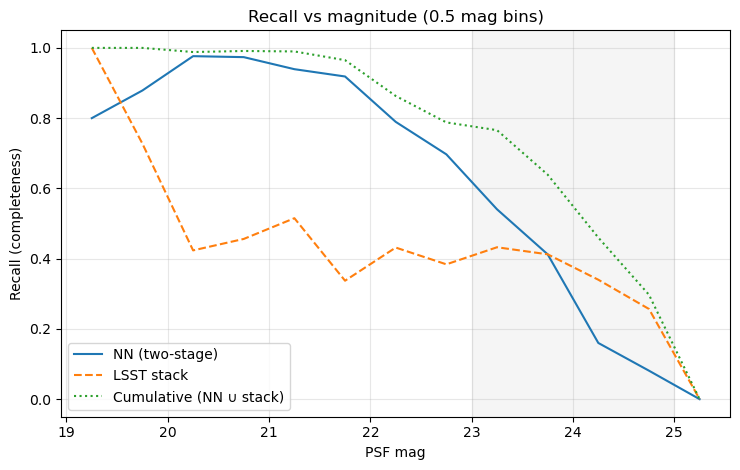

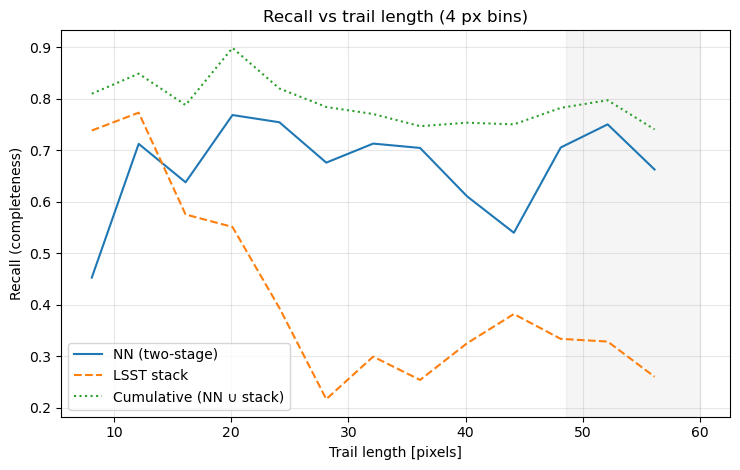

In [26]:
def bin_recall_with_cumulative(df, mag_col, bins):
    out = []
    for lo, hi in zip(bins[:-1], bins[1:]):
        sel = (df[mag_col] >= lo) & (df[mag_col] < hi)
        sub = df[sel]
        if len(sub) == 0:
            out.append((lo, hi, 0, np.nan, np.nan, np.nan))
            continue
        nn_det  = sub["nn_detected"].astype(bool)
        stk_det = sub["stack_detected"].astype(bool)
        cum_det = nn_det | stk_det
        n = len(sub)
        rec_nn  = nn_det.sum()  / n
        rec_stk = stk_det.sum() / n
        rec_cum = cum_det.sum() / n
        out.append((lo, hi, n, rec_nn, rec_stk, rec_cum))
    return pd.DataFrame(out, columns=["mag_lo","mag_hi","count","R_NN","R_Stack","R_Cum"])

mag_col = None
for c in ["PSF_mag","integrated_mag","mag"]:
    if c in cat2.columns:
        mag_col = c
        break

if mag_col is not None:
    bins = np.arange(18, 26.01, 0.5)
    df_mag = bin_recall_with_cumulative(cat2, mag_col, bins)

    mid = (bins[:-1]+bins[1:])/2
    plt.figure(figsize=(7.5,4.8))
    plt.plot(mid, df_mag["R_NN"],    label="NN (two-stage)")
    plt.plot(mid, df_mag["R_Stack"], label="LSST stack", ls="--")
    plt.plot(mid, df_mag["R_Cum"],   label="Cumulative (NN ∪ stack)", ls=":")
    plt.axvspan(23, 25, color="gray", alpha=0.08)
    plt.xlabel(mag_col.replace("_"," "))
    plt.ylabel("Recall (completeness)")
    plt.title("Recall vs magnitude (0.5 mag bins)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    #display(df_mag[(df_mag.mag_lo>=23)&(df_mag.mag_hi<=25)].reset_index(drop=True))
else:
    print("No magnitude column found in catalog; skipping mag-binned recall.")

if "trail_length" in cat2.columns:
    bins_len = np.arange(cat2["trail_length"].min(), cat2["trail_length"].max()+0.5, 4)
    df_len = bin_recall_with_cumulative(cat2, "trail_length", bins_len)

    mid_len = (bins_len[:-1]+bins_len[1:])/2
    plt.figure(figsize=(7.5,4.8))
    plt.plot(mid_len, df_len["R_NN"],    label="NN (two-stage)")
    plt.plot(mid_len, df_len["R_Stack"], label="LSST stack", ls="--")
    plt.plot(mid_len, df_len["R_Cum"],   label="Cumulative (NN ∪ stack)", ls=":")
    # shade long-trail region (adjust limits to your dataset)
    plt.axvspan(np.percentile(cat2["trail_length"],80),
                cat2["trail_length"].max(), color="gray", alpha=0.08)
    plt.xlabel("Trail length [pixels]")
    plt.ylabel("Recall (completeness)")
    plt.title("Recall vs trail length (4 px bins)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

   #display(df_len.head(10))
else:
    print("Column 'trail_length' not found; skipping trail-length recall plot.")


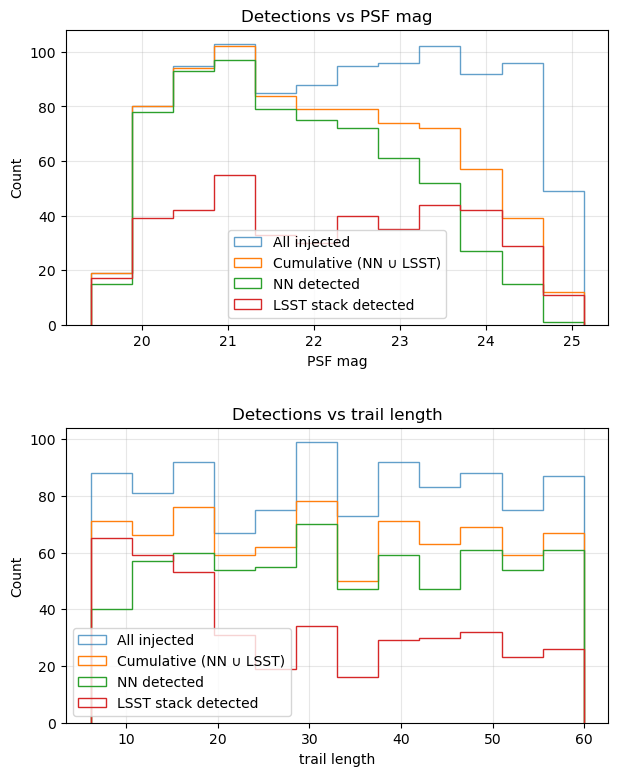

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_detection_histograms(cat, mag_col="PSF_mag", trail_col="trail_length", bins_mag=12, bins_len=12):
    """Draws histograms of detected vs all for magnitude and trail length."""
    # Helper to pick magnitude column automatically
    if mag_col not in cat.columns:
        for c in ["PSF_mag","integrated_mag","mag"]:
            if c in cat.columns:
                mag_col = c
                break
    if mag_col not in cat.columns:
        print("No magnitude column found!")
        return

    # convenience boolean arrays
    nn_det  = cat["nn_detected"].astype(bool)
    stk_det = cat["stack_detected"].astype(bool)
    cum_det = nn_det | stk_det

    # ===== Figure setup =====
    fig, axes = plt.subplots(2, 1, figsize=(7,9))
    fig.subplots_adjust(hspace=0.35)

    # ===== (1) Detections vs magnitude =====
    vals = cat[mag_col].to_numpy()
    vals = vals[np.isfinite(vals)]
    edges_mag = np.histogram_bin_edges(vals, bins=bins_mag)

    axes[0].hist(cat[mag_col], bins=edges_mag, histtype="step", label="All injected", color="C0", alpha=0.7)
    axes[0].hist(cat.loc[cum_det, mag_col], bins=edges_mag, histtype="step", label="Cumulative (NN ∪ LSST)", color="C1")
    axes[0].hist(cat.loc[nn_det, mag_col],  bins=edges_mag, histtype="step", label="NN detected", color="C2")
    axes[0].hist(cat.loc[stk_det, mag_col], bins=edges_mag, histtype="step", label="LSST stack detected", color="C3")
    axes[0].set_xlabel(mag_col.replace("_"," "))
    axes[0].set_ylabel("Count")
    axes[0].set_title(f"Detections vs {mag_col.replace('_',' ')}")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # ===== (2) Detections vs trail length =====
    if trail_col in cat.columns:
        vals = cat[trail_col].to_numpy()
        vals = vals[np.isfinite(vals)]
        edges_len = np.histogram_bin_edges(vals, bins=bins_len)

        axes[1].hist(cat[trail_col], bins=edges_len, histtype="step", label="All injected", color="C0", alpha=0.7)
        axes[1].hist(cat.loc[cum_det, trail_col], bins=edges_len, histtype="step", label="Cumulative (NN ∪ LSST)", color="C1")
        axes[1].hist(cat.loc[nn_det, trail_col],  bins=edges_len, histtype="step", label="NN detected", color="C2")
        axes[1].hist(cat.loc[stk_det, trail_col], bins=edges_len, histtype="step", label="LSST stack detected", color="C3")
        axes[1].set_xlabel(trail_col.replace("_"," "))
        axes[1].set_ylabel("Count")
        axes[1].set_title(f"Detections vs {trail_col.replace('_',' ')}")
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()
    else:
        axes[1].axis("off")
        print(f"Column '{trail_col}' not found, skipped lower plot.")

    plt.show()

# === Run it ===
plot_detection_histograms(cat2, mag_col="PSF_mag", trail_col="trail_length", bins_mag=12, bins_len=12)


In [14]:
cm_px, prf_px = pixelwise_confusion(p_full, gt_full, thr=THRESHOLD)
print_confusion_matrix(cm_px, title=f"Pixelwise @ thr={THRESHOLD}")
print(f"Pixelwise: P={prf_px[0]:.4f} R={prf_px[1]:.4f} F1={prf_px[2]:.4f} F2={prf_px[3]:.4f}")


Pixelwise @ thr=0.5


,Pred +,Pred -
Actual +,1157727,2462238
Actual -,1617091,809162944


Pixelwise: P=0.3198 R=0.4172 F1=0.3621 F2=0.3933


In [15]:
pred_pos = (s_clf >= CLF_THR)
tp = int(((pred_pos==True) & (Y==1)).sum())
fp = int(((pred_pos==True) & (Y==0)).sum())
fn = int(((pred_pos==False) & (Y==1)).sum())
tn = int(((pred_pos==False) & (Y==0)).sum())
prec = tp / max(tp+fp, 1); rec = tp / max(tp+fn, 1)
f1 = 2*prec*rec / max(prec+rec, 1e-12)
beta2 = 2.0
f2 = (1+beta2**2)*prec*rec / max(beta2**2*prec + rec, 1e-12)
print(f"Objectwise (clf@{CLF_THR:.2f}): P={prec:.4f} R={rec:.4f} F1={f1:.4f} F2={f2:.4f}")


Objectwise (clf@0.50): P=0.5003 R=1.0000 F1=0.6669 F2=0.8335
